# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
# download the dog images from AWS
#!wget "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"

In [2]:
#unzip the images to the expected directory
#!unzip dogImages.zip -d dogImages
#!rm dogImages.zip

In [3]:
# download the human images from AWS
#!wget "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip"

In [4]:
# unzip the images to the expected directory
#!unzip lfw.zip -d lfw
#!rm lfw.zip

In [5]:
# Download the VGG-16 bottleneck features for the dog dataset
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz

In [6]:
# create the expected directory and move the file
#!mkdir bottleneck_features
#!mv DogVGG16Data.npz bottleneck_features/DogVGG16Data.npz

In [7]:
# create the needed conda environment for Linux, local GPU support using tensorflows as the Keras backend
#!conda env create -f requirements/dog-linux.yml
#!source activate dog-project
#!pip install -r requirements/requirements-gpu.txt

In [8]:
#!python -m ipykernel install --user --name dog-project --display-name "dog-project"

In [1]:
import sys
sys.path.insert(0, "../keras")

from sklearn.datasets import load_files       
import keras
#from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = keras.utils.np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories|.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories|.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(1999)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [3]:
# print the keras version as it was used to support multigpu training using tensorflow as the keras processing backend
print(keras.__version__)

2.1.3


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


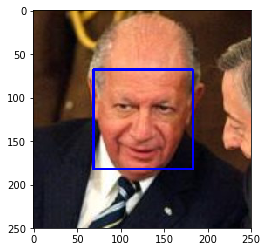

In [4]:
import cv2     
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3],0)
img_bgr = cv2.imread(human_files[3])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img_bgr,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## Test the performance of the face_detector algorithm on the images in human_files_short and dog_files_short.

def find_face(file_list):
    num_human_faces = 0
    for f in file_list:
        num_human_faces += 1 if face_detector(f) else 0
    return num_human_faces

print(str(find_face(human_files_short)) + ' human faces among ' + str(len(human_files_short)) + ' human images.')
print(str(find_face(dog_files_short)) + ' human faces among ' + str(len(dog_files_short)) + ' dog images.')

99 human faces among 100 human images.
11 human faces among 100 dog images.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__
No, Haar cascades are appropiate for face detection in images with a clearly presented face.  We can say, "If you would like to use this app/service please submit photos with a clearly presented face."  (This algorithm was trained to detect faces not humans.)  

If we want to detect people, we should use a network that was trained for that purpose (e.g. using human photos vs face photos).    

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [11]:
# ## Optionally reported on the performance of another face detection algorithm (Facenet) on the LFW dataset
# import os
# import tensorflow as tf
# import numpy as np
# import argparse
# import lfw
# import os
# import sys
# import math
# from sklearn import metrics
# from scipy.optimize import brentq
# from scipy import interpolate
# from tensorflow.python.platform import gfile
# from scipy import misc
# #1 Download pretrained model from https://drive.google.com/file/d/0B5MzpY9kBtDVZ2RpVDYwWmxoSUk 
# # to models/facenet/20170512-110547 !mkdir "models"
# batch_size = 900
# image_size = 224
# paths_batch = human_files_short
# facenet_stored_model = r'models/facenet/20170512-110547/20170512-110547.pb'



# def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10):
#     assert(embeddings1.shape[0] == embeddings2.shape[0])
#     assert(embeddings1.shape[1] == embeddings2.shape[1])
#     nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
#     nrof_thresholds = len(thresholds)
#     k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    
#     tprs = np.zeros((nrof_folds,nrof_thresholds))
#     fprs = np.zeros((nrof_folds,nrof_thresholds))
#     accuracy = np.zeros((nrof_folds))
    
#     diff = np.subtract(embeddings1, embeddings2)
#     dist = np.sum(np.square(diff),1)
#     indices = np.arange(nrof_pairs)
    
#     for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        
#         # Find the best threshold for the fold
#         acc_train = np.zeros((nrof_thresholds))
#         for threshold_idx, threshold in enumerate(thresholds):
#             _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
#         best_threshold_index = np.argmax(acc_train)
#         for threshold_idx, threshold in enumerate(thresholds):
#             tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
#         _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])
          
#     tpr = np.mean(tprs,0)
#     fpr = np.mean(fprs,0)
#     return tpr, fpr, accuracy

# def calculate_accuracy(threshold, dist, actual_issame):
#     predict_issame = np.less(dist, threshold)
#     tp = np.sum(np.logical_and(predict_issame, actual_issame))
#     fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
#     tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
#     fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
  
#     tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
#     fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
#     acc = float(tp+tn)/dist.size
#     return tpr, fpr, acc


  
# def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10):
#     assert(embeddings1.shape[0] == embeddings2.shape[0])
#     assert(embeddings1.shape[1] == embeddings2.shape[1])
#     nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
#     nrof_thresholds = len(thresholds)
#     k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    
#     val = np.zeros(nrof_folds)
#     far = np.zeros(nrof_folds)
    
#     diff = np.subtract(embeddings1, embeddings2)
#     dist = np.sum(np.square(diff),1)
#     indices = np.arange(nrof_pairs)
    
#     for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
      
#         # Find the threshold that gives FAR = far_target
#         far_train = np.zeros(nrof_thresholds)
#         for threshold_idx, threshold in enumerate(thresholds):
#             _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
#         if np.max(far_train)>=far_target:
#             f = interpolate.interp1d(far_train, thresholds, kind='slinear')
#             threshold = f(far_target)
#         else:
#             threshold = 0.0
    
#         val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])
  
#     val_mean = np.mean(val)
#     far_mean = np.mean(far)
#     val_std = np.std(val)
#     return val_mean, val_std, far_mean


# def load_data(image_paths, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
#     nrof_samples = len(image_paths)
#     images = np.zeros((nrof_samples, image_size, image_size, 3))
#     for i in range(nrof_samples):
#         img = misc.imread(image_paths[i])
#         if img.ndim == 2:
#             img = to_rgb(img)
#         if do_prewhiten:
#             img = prewhiten(img)
#         img = crop(img, do_random_crop, image_size)
#         img = flip(img, do_random_flip)
#         images[i,:,:,:] = img
#     return images

# def prewhiten(x):
#     mean = np.mean(x)
#     std = np.std(x)
#     std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
#     y = np.multiply(np.subtract(x, mean), 1/std_adj)
#     return y  

# def evaluate(embeddings, actual_issame, nrof_folds=10):
#     # Calculate evaluation metrics
#     thresholds = np.arange(0, 4, 0.01)
#     embeddings1 = embeddings[0::2]
#     embeddings2 = embeddings[1::2]
#     tpr, fpr, accuracy = calculate_roc(thresholds, embeddings1, embeddings2,
#         np.asarray(actual_issame), nrof_folds=nrof_folds)
#     thresholds = np.arange(0, 4, 0.001)
#     val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
#         np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds)
#     return tpr, fpr, accuracy, val, val_std, far

# def crop(image, random_crop, image_size):
#     if image.shape[1]>image_size:
#         sz1 = int(image.shape[1]//2)
#         sz2 = int(image_size//2)
#         if random_crop:
#             diff = sz1-sz2
#             (h, v) = (np.random.randint(-diff, diff+1), np.random.randint(-diff, diff+1))
#         else:
#             (h, v) = (0,0)
#         image = image[(sz1-sz2+v):(sz1+sz2+v),(sz1-sz2+h):(sz1+sz2+h),:]
#     return image

# def flip(image, random_flip):
#     if random_flip and np.random.choice([True, False]):
#         image = np.fliplr(image)
#     return image

# def load_model(model):
#     # Check if the model is a model directory (containing a metagraph and a checkpoint file)
#     #  or if it is a protobuf file with a frozen graph
#     model_exp = os.path.expanduser(model)
#     if (os.path.isfile(model_exp)):
#         print('Model filename: %s' % model_exp)
#         with gfile.FastGFile(model_exp,'rb') as f:
#             graph_def = tf.GraphDef()
#             graph_def.ParseFromString(f.read())
#             tf.import_graph_def(graph_def, name='')
#     else:
#         print('Model directory: %s' % model_exp)
#         meta_file, ckpt_file = get_model_filenames(model_exp)
        
#         print('Metagraph file: %s' % meta_file)
#         print('Checkpoint file: %s' % ckpt_file)
      
#         saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file))
#         saver.restore(tf.get_default_session(), os.path.join(model_exp, ckpt_file))

# with tf.Graph().as_default():

#     with tf.Session() as sess:

#         # Load the model
#         load_model(facenet_stored_model)

#         # Get input and output tensors
#         images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
#         embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
#         phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

#         #image_size = images_placeholder.get_shape()[1]  # For some reason this doesn't work for frozen graphs

#         embedding_size = embeddings.get_shape()[1]

#         # Run forward pass to calculate embeddings
#         print('Runnning forward pass on images')
#         nrof_images =  900
#         nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
#         nrof_batches = 1
#         emb_array = np.zeros((nrof_images, embedding_size))
  
#         for i in range(nrof_batches):
#             start_index = i*batch_size
#             end_index = min((i+1)*batch_size, nrof_images)
#             #paths_batch = paths[start_index:end_index]
#             images = load_data(paths_batch, False, False, image_size,do_prewhiten=False)
#             feed_dict = { images_placeholder:images, phase_train_placeholder:False }
#             emb_array[0:900,:] = sess.run(embeddings, feed_dict=feed_dict)
        
#         tpr, fpr, accuracy, val, val_std, far = evaluate(emb_array, 
#             actual_issame, nrof_folds=args.lfw_nrof_folds)

#         print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
#         print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))

#         auc = metrics.auc(fpr, tpr)
#         print('Area Under Curve (AUC): %1.3f' % auc)
#         eer = brentq(lambda x: 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)
#         print('Equal Error Rate (EER): %1.3f' % eer)



---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [11]:
### Test the performance of the dog_detector function on the images in human_files_short and dog_files_short

def find_dogs(file_list):
    num_dog_faces = 0
    for f in file_list:
        num_dog_faces += 1 if dog_detector(f) else 0
    return num_dog_faces

print(str(find_dogs(human_files_short)) + ' dog faces among ' + str(len(human_files_short)) + ' human images.')
print(str(find_dogs(dog_files_short)) + ' dog faces among ' + str(len(dog_files_short)) + ' dog images.')

0 dog faces among 100 human images.
100 dog faces among 100 dog images.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:03<00:00, 227.83it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I experimented many times with different activation functions, image sizes, step sizes, and kernel sizes with different numbers and types of layers including dropout, dense, flatten, convolution and max pooling. I also pulled the latest Keras source to leverage multiple GPU training to speed my performance analysis iterations. Callbacks were stacking on an open issue, so after tuning, I went back and retrained the network using the working callback approach.

The network I ended up with was pretty shallow regarding the number of layers.  In 1998, I focused my capstone project for undergrad on a 'smart camera system.'  I wanted to use more layers back then (we didn't have GPUs for training, or handly libraries then, only our c/c++ code) but was limited on time.  My goal was to make it work and improve, and I met that goal.

Fast forward 20 years, and we can pull pertained models, slice the last layer, freeze the weights, slap a Dense layer for the number of desired outputs, augment the limited training inputs, and train it to 95% validation set accuracy in less than 5 minutes!

The below setup uses nine layers, and even with multiple GPU training (using 2x TitanX), it takes considerable time to train.  Naturally, I'd like to have a much deeper network, but even optimizing the below nine-layer network took about two months with daily training evolutions. I don't know how much more efficient Google's TPUs or Xilinx FPGAs would be at this specialized type of training.  I imagine I'll reflect back in 10 years and training a 180 layer network on ASIC-based hardware from scratch will take less than 5 minutes :-) 

For today, I'll settle for 10% test accuracy (as noted below).  CNN's are great because they can generate commonalities that best differentiate the input against a scale of order.  Lower level 'kernels' capture edges while higher level 'features' can represent objects like a tire.  The Dense layers persist information regarding the presented node weights against an operational objective. 

**I wonder if adding different input signals (different dimension data) into the architecture aids in accuracy.   Would audio, radar or lidar data improve object detection accuracy?  Analogous to adding 30 hyperspectral images planes in place of RGB, perhaps easily integrating different dimension measurement or signals data could make detection even more accurate.**

In [13]:
#reference: https://www.researchgate.net/figure/318909782_The-architecture-of-the-CNN-learned-in-our-work-for-N-32-and-l-2-The-numbers-along
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Define architecture
img_width, img_height = 224, 224

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(img_width, img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same', strides=(2,2)))

model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same', strides=(2,2)))

model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same', strides=(2,2)))
# padding valid?

#model.add(AveragePooling2D(pool_size=(2,2), strides = None, padding='valid'))
#model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), padding='same', strides=(1,1) ))
#model.add(Dropout(0.2))
#model.add(GlobalAveragePooling2D())
#model.add(GlobalMaxPooling2D())
# activations selu, softmax, elu, softplus, tanh, sigmoid, relu, softsign
#model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(320, activation='relu'))


#model.add(Dense(128, activation='relu'))

model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))


model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 16)      4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11664)             0         
__________

### Compile the Model

In [14]:
#from: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
from keras.callbacks import Callback
from IPython.display import clear_output
from matplotlib import pyplot as plt

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

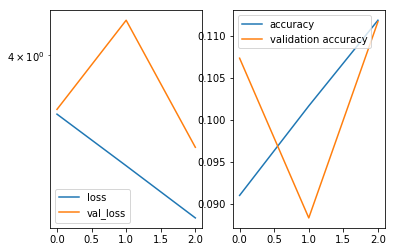

334/334 [==============================] - 61s 183ms/step - loss: 3.7796 - acc: 0.1118 - val_loss: 3.8738 - val_acc: 0.1117


In [16]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  
from keras.preprocessing import image 
from keras.utils import multi_gpu_model

# augment the training data
nb_train_samples = 6680
nb_validation_samples = 835
# epochs = 50
batch_size = 20

train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    'dogImages/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'dogImages/valid',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical', shuffle=False)



#for f in train_files:
    #img = image.load_img(f)  # this is a PIL image
    #x = image.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    #x = x.reshape((1,
# augment the training data) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    #file_dir = os.path.dirname(os.path.realpath(f))
    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    #i = 0
    #for batch in ImageDataGenerator.flow_from_directory(file_dir, batch_size=1, save_to_dir=file_dir, save_prefix=os.path.splitext(f)[0], 
    #                          save_format='jpeg'):
    #    i += 1
    #    if i > 20:
    #        break  # otherwise the generator would loop indefinitely

        

checkpointer = ModelCheckpoint(
    filepath='saved_models/weights.augmented.best.from_scratch.hdf5',  verbose=1, save_best_only=True)

# # training params
batch_size = 20
epochs = 3

# # use parallel model with keras from master branch (latest)
# parallel_model = multi_gpu_model(model, gpus=2)
# parallel_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# # fit here to see the difference
# parallel_model.fit_generator(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
#     verbose=1,
#     #callbacks=[checkpointer,plot],
#     steps_per_epoch=nb_train_samples // batch_size)


# non-gpu model, since callbacks stack with latest master code
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# fit here to see the difference
model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=1,
    callbacks=[checkpointer,plot],
    steps_per_epoch=nb_train_samples // batch_size)

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [17]:
# ^^^implemented above to support multigpu, augmented training, max validation ~19%^^^
# BELOW code is limited, e.g. do not modify,so we run the model / 
# from keras.callbacks import ModelCheckpoint  

# ###  the number of epochs that used to train the model
# epochs = 2
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


### Do NOT modify the code below this line.

# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
#                                verbose=1, save_best_only=True)

# model.fit(train_tensors, train_targets, 
#           validation_data=(valid_tensors, valid_targets),
#           epochs=epochs, batch_size=20, callbacks=[checkpointer,plot], verbose=1)

### Load the Model with the Best Validation Loss

In [18]:
model.load_weights('saved_models/weights.augmented.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 10.2871%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [38]:

bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [39]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [40]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [41]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6660/6680 [============================>.] - ETA: 0s - loss: 12.5304 - acc: 0.1162
Epoch 00001: val_loss improved from inf to 11.21984, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 175us/step - loss: 12.5252 - acc: 0.1166 - val_loss: 11.2198 - val_acc: 0.1832
Epoch 2/20
6480/6680 [============================>.] - ETA: 0s - loss: 10.1265 - acc: 0.2699
Epoch 00002: val_loss improved from 11.21984 to 10.00066, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 128us/step - loss: 10.1325 - acc: 0.2698 - val_loss: 10.0007 - val_acc: 0.2659
Epoch 3/20
6420/6680 [===========================>..] - ETA: 0s - loss: 9.3539 - acc: 0.3452
Epoch 00003: val_loss improved from 10.00066 to 9.69420, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 130us/step - loss: 9.3449 - acc: 0.3454 - v

### Load the Model with the Best Validation Loss

In [43]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [44]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: ' + str( test_accuracy))

Test accuracy: 45.6937799043


### Predict Dog Breed with the Model

In [45]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [30]:
### Obtain bottleneck features from Resnet 50

pretrained_model_list = ['DogInceptionV3Data.npz','DogVGG16Data.npz','DogResnet50Data.npz','DogXceptionData.npz']

model_id = 3
bottleneck_features = np.load('bottleneck_features/'+pretrained_model_list[model_id])
train_final_model = bottleneck_features['train']
valid_final_model = bottleneck_features['valid']
test_final_model = bottleneck_features['test']
    


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I experimented many times with different activation functions, image sizes, step sizes, and kernel sizes with different numbers and types of layers including dropout, dense, flatten, conv and maxpooling.  I also pulled the latest Keras source to leverage multigpu training to speed my performance analysis.  Callbacks were stacking on an open issue, so after tuning, I went back and retrained the network using the working callback approach.

In [31]:
###   architecture
final_model = Sequential()
### Define architecture

final_model.add(GlobalAveragePooling2D(input_shape=train_final_model.shape[1:]))
final_model.add(Dense(320, activation='relu'))
#final_model.add(Dropout(0.45))
final_model.add(Dense(320, activation='relu'))
final_model.add(Dropout(0.45))
final_model.add(Dense(133, activation='softmax'))
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 320)               655680    
_________________________________________________________________
dense_5 (Dense)              (None, 320)               102720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               42693     
Total params: 801,093
Trainable params: 801,093
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [32]:
### Compile the model optimizer='sgd','rmsprop','adam','nadam'
final_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

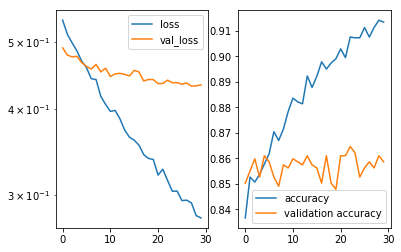

6680/6680 [==============================] - 2s 255us/step - loss: 0.2774 - acc: 0.9135 - val_loss: 0.4332 - val_acc: 0.8587


In [159]:
### Train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.final_model.hdf5', verbose=1, save_best_only=True)

final_model.fit(train_final_model, train_targets, validation_data=(valid_final_model, valid_targets),
          epochs=30, batch_size=40, callbacks=[checkpointer,plot], verbose=1)

In [ ]:
Performance Summary

Vgg16 validation score after 20 epochs: 0.7174
InceptionV3 validation score after 20 epochs: 0.8395
Resnet50 validation score after 20 epochs: 0.7617
Xception validation score after 20 epochs: 0.8180 rmsprop
Xception validation score after 20 epochs: 0.8563 sgd
Xception validation score after 20 epochs: 0.8635 adadelta
    


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [33]:
### Load the model weights with the best validation loss
final_model.load_weights('saved_models/weights.best.final_model.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [166]:
### Calculate classification accuracy on the test dataset.
final_model_predictions = [np.argmax(final_model.predict(np.expand_dims(feature, axis=0))) for feature in test_final_model]

# report test accuracy
final_test_accuracy = 100*np.sum(np.array(final_model_predictions)==np.argmax(test_targets, axis=1))/len(final_model_predictions)
print('Test accuracy: ' + str( final_test_accuracy))

Test accuracy: 84.9282296651


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [34]:
### A function that takes a path to an image as inputand returns the dog breed that is predicted by the model.


from extract_bottleneck_features import *

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def Xception_breed(img_path):
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    predicted_vector = final_model.predict(bottleneck_feature)

    breed = dog_names[np.argmax(predicted_vector)]
    if dog_detector(img_path):
        race = 'Dog'
    else:
        if face_detector(img_path) > 0:
            race = 'Human'
        else:
            race = 'Not Human'
    return race, breed

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [35]:
### Breed_discovery function
def predict_dog_breed(img_path):
    race, breed = Xception_breed(img_path)
    return (race, breed)


In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline

def show_image(image_path):
    img=mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/home/cbios/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ It is better.  I would like to use augmented training to add greater robustness and validation accuracy.  I'd also like to add more training data.  More data would allow the model to better differentiate between breeds.  Finally, striding the prediction algorithm over the input data may avoid scaling issues that input distortions into the model.  Also a meta model or ensemble approach may yeild additional robustness by optimizing prediction selection accross several source models.

I am happy with the results as it guessed all breeds and humans correctly.  I like that it identified the 1930 photo of Major General Smedley Butler as a Bulldog since 'bulldog' is pretty close to 'devil dog' (https://en.wikipedia.org/wiki/Devil_Dog).

I also did the extra work referenced in the project description over at Kaggle.  My results there (https://www.kaggle.com/ricklentz/exercise-data-augmentation) were also good, ~95%

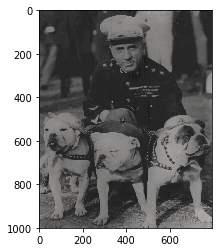

Human that looks like dog breed Bulldog



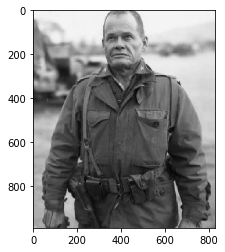

Human that looks like dog breed Brussels_griffon



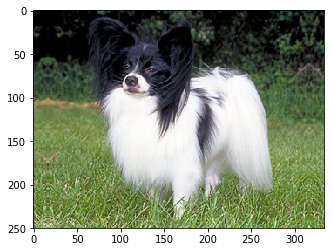

Dog of breed Papillon


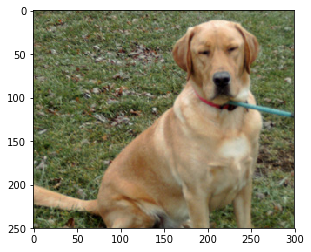

Dog of breed Labrador_retriever


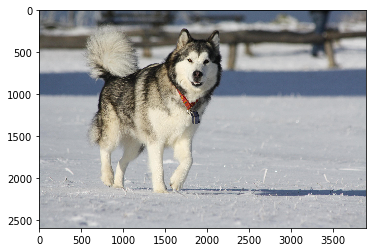

Dog of breed Alaskan_malamute


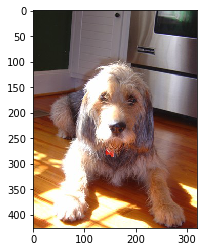

Dog of breed Otterhound


In [40]:
## Execute your algorithm from Step 6 on at least 6 images on your computer.
import os, random

num_rand_validation_images = 4

def dog_breed_match(img_path):
    try:
        detected_human_face = face_detector(img_path)
        detected_dog = dog_detector(img_path)
        if not(detected_human_face or detected_dog): 
            print('Did not detect a human or dog.')
            show_image(img_path)
        elif detected_dog:
            race, breed = predict_dog_breed(img_path)
            show_image(img_path)
            print('Dog of breed ' + breed)
        else:
            race, breed = predict_dog_breed(img_path)
            show_image(img_path)
            print('Human that looks like dog breed ' + breed)
            show_image(breed)
    except:
            print('')
        
#randomly select files and present results
test_validation_files = valid_files[:num_rand_validation_images]


# add two images
import requests

urls = ['https://cbios.co/Content/smedley_bulter_1930.png','https://cbios.co/Content/chesty_puller.png']
other_files = list()
for idx,url in enumerate(urls):
    filename = str(idx)+'.png'
    file_data = requests.get(url).content
    with open(filename, mode='wb') as localfile:
        localfile.write(file_data)
    other_files.append(filename)

for file in other_files:
    dog_breed_match(file)
    
for file in test_validation_files:
    dog_breed_match(file)
    

    